In [2]:
# imports

import pandas as pd
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 20)

import numpy as np
import gc

#import catboost ## thanks to yandex ! :) 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
#from tqdm import tqdm_notebook

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
import statsmodels.api as sm
from statsmodels.iolib.table import SimpleTable
# info about itertools.product: 
# https://pythonworld.ru/moduli/modul-itertools.html
# https://docs.python.org/2/library/itertools.html
from itertools import product

# Работа с данными

Объеденим данные по месяцам:

In [3]:
eff_train = pd.read_csv('data/eff_train/eff_train1.csv', sep=';')
for x in range(2,11):
    eff_train_new = pd.read_csv('data/eff_train/eff_train{}.csv'.format(x), sep=';')
    eff_train = pd.concat([eff_train, eff_train_new])
eff_train = eff_train.rename(columns = {' timestamp':'timestamp', ' value':'value', ' quality':'quality'})
eff_train.head(2)

,tag,timestamp,value,quality
0,Efficiency,01.10.2016 0:00,16137.70,Good
1,Efficiency,01.10.2016 0:00,16060.55,Good


In [4]:
eff_test1 = pd.read_csv('data/eff_test/eff_test1.csv', sep=';')
eff_test2 = pd.read_csv('data/eff_test/eff_test2.csv', sep=';')
eff_test = pd.concat([eff_test1, eff_test2])
eff_test = eff_test.rename(columns = {' timestamp':'timestamp', ' value':'value', ' quality':'quality'})
eff_test.head(2)

,tag,timestamp,value,quality
0,Efficiency,01.08.2017 0:00,16836.91,Good
1,Efficiency,01.08.2017 0:00,17145.51,Good


In [5]:
energy_train = pd.read_csv('data/energy_cons_train/Energy_cons_train1.csv', sep=';')
for x in range(2,11):
    energy_train_new = pd.read_csv('data/energy_cons_train/Energy_cons_train{}.csv'.format(x), sep=';')
    energy_train = pd.concat([energy_train, energy_train_new])
energy_train = energy_train.rename(columns = { ' timestamp':'timestamp', ' value':'value', ' quality':'quality'})
energy_train.head(2)

,tag,timestamp,value,quality
0,Energy_cons,01.10.2016 0:01,20.347508,Good
1,Energy_cons,01.10.2016 0:02,20.24238,Good


In [6]:
energy_test = pd.read_csv('data/energy_cons_test/Energy_cons_test1.csv', sep=';')
x=2
energy_test_new = pd.read_csv('data/energy_cons_test/Energy_cons_test{}.csv'.format(x), sep=';')
energy_test = pd.concat([energy_test, energy_test_new])
energy_test = energy_test.rename(columns = { ' timestamp':'timestamp', ' value':'value', ' quality':'quality'})
energy_test.head(2)

,tag,timestamp,value,quality
0,Energy_cons,01.08.2017 0:01,17.324733,Good
1,Energy_cons,01.08.2017 0:02,17.46305,Good


In [7]:
qual_train = pd.read_csv('data/qual_train/qual_train1.csv', sep=';') 
for x in range(2,11): 
    qual_train_new = pd.read_csv('data/qual_train/qual_train{}.csv'.format(x), sep=';') 
    qual_train = pd.concat([qual_train, qual_train_new], ignore_index = True) 
qual_train = qual_train.rename(columns = { ' timestamp':'timestamp', ' value':'value', ' quality':'quality'}) 
qual_train.head(2)

,tag,timestamp,value,quality
0,Quality,01.10.2016 0:38,2.2,Good
1,Quality,01.10.2016 1:02,2.2,Good


In [8]:
qual_test = pd.read_csv('data/qual_test/qual_test1.csv', sep=';') 
x=2 
qual_test_new = pd.read_csv('data/qual_test/qual_test{}.csv'.format(x), sep=';') 
qual_test = pd.concat([qual_test, qual_test_new]) 
qual_test = qual_test.rename(columns = { ' timestamp':'timestamp', ' value':'value', ' quality':'quality'}) 
qual_test.head(2)

,tag,timestamp,value,quality
0,Quality,01.08.2017 0:14,2.2,Good
1,Quality,01.08.2017 0:38,2.2,Good


Объеденим трэйн и тест:

In [9]:
eff_all = pd.concat([eff_train, eff_test])
qual_all = pd.concat([qual_train, qual_test])
energy_all = pd.concat([energy_train, energy_test])

преобразуем колонку timestamp в тип datetime:

In [10]:
eff_all["timestamp"] = pd.to_datetime(eff_all["timestamp"], format = '%d.%m.%Y %H:%M')
qual_all["timestamp"] = pd.to_datetime(qual_all["timestamp"], format = '%d.%m.%Y %H:%M')
energy_all["timestamp"] = pd.to_datetime(energy_all["timestamp"], format = '%d.%m.%Y %H:%M')

In [11]:
eff_all.head(2)

,tag,timestamp,value,quality
0,Efficiency,2016-10-01,16137.70,Good
1,Efficiency,2016-10-01,16060.55,Good


In [12]:
qual_all.head(2)

,tag,timestamp,value,quality
0,Quality,2016-10-01 00:38:00,2.2,Good
1,Quality,2016-10-01 01:02:00,2.2,Good


In [13]:
energy_all.head()

,tag,timestamp,value,quality
0,Energy_cons,2016-10-01 00:01:00,20.347508,Good
1,Energy_cons,2016-10-01 00:02:00,20.24238,Good
2,Energy_cons,2016-10-01 00:03:00,20.208391,Good
3,Energy_cons,2016-10-01 00:04:00,20.239189,Good
4,Energy_cons,2016-10-01 00:05:00,20.262808,Good


Уберем мусор в данных:

In [14]:
energy_all["value"] = pd.to_numeric(energy_all["value"], downcast = 'float', errors='coerse')
energy_all = energy_all[energy_all["value"].notnull()]

In [15]:
energy_all = energy_all[energy_all["quality"] == "Good"]
qual_all = qual_all[qual_all["quality"] == "Good"]
eff_all = eff_all[eff_all["quality"] == "Good"]
eff_all = eff_all[eff_all["value"] > 0.0]
#qual_all = qual_all[qual_all["value"] > 0.0]
#energy_all = energy_all[energy_all["value"] > 0.0]

# Визуализируем данные

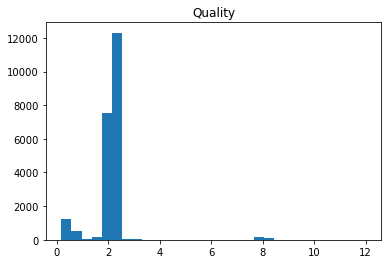

In [16]:
plt.hist(qual_all["value"], 30)
plt.title("Quality")
plt.show()

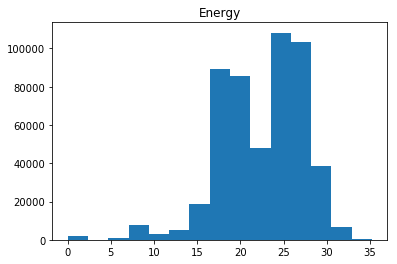

In [17]:
plt.hist(energy_all["value"], 15)
plt.title("Energy")
plt.show()

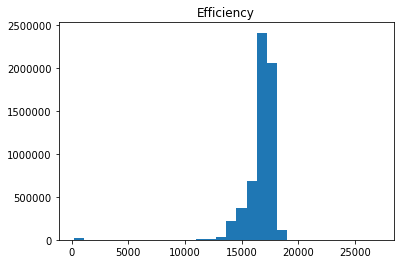

In [18]:
plt.hist(eff_all["value"], 30)
plt.title("Efficiency")
plt.show()

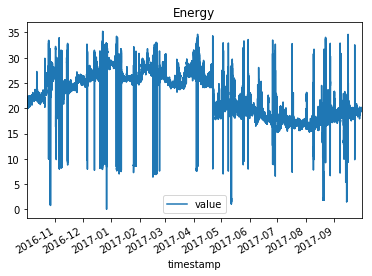

In [19]:
energy_all.plot(x = 'timestamp', y = 'value')
plt.title("Energy")

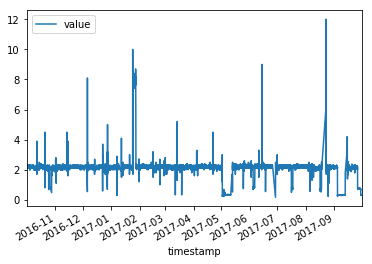

In [20]:
qual_all.plot(x = 'timestamp', y = 'value')

In [21]:
eff_all.shape

(5920437, 4)

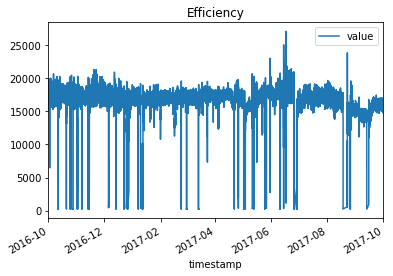

In [22]:
eff_all.plot(x = 'timestamp', y = 'value')
plt.title("Efficiency")

In [23]:
gb = eff_all.groupby("timestamp").value.mean()
gb.head()

timestamp
2016-10-01 00:00:00    16751.067273
2016-10-01 00:01:00    16669.921667
2016-10-01 00:02:00    16979.655833
2016-10-01 00:03:00    16527.832500
2016-10-01 00:04:00    16829.427500
Name: value, dtype: float64

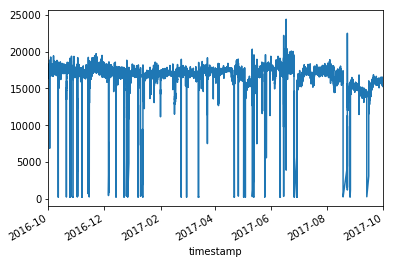

In [24]:
gb.plot()

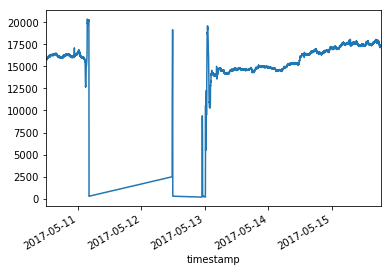

In [25]:
gb_lol = gb[gb.index > '2017-05-10T12:00:00.000000000']
gb_lol = gb_lol[gb_lol.index < '2017-05-15T18:30:00.000000000']
gb_lol.plot()

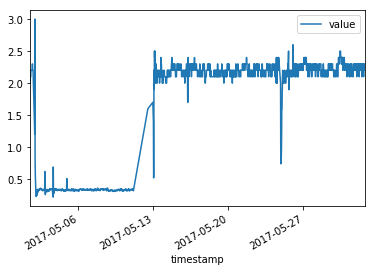

In [26]:
qual_lol = qual_all[qual_all['timestamp'] > '2017-05-01T12:00:00.000000000']
qual_lol = qual_lol[qual_lol['timestamp'] < '2017-06-01T18:30:00.000000000']
qual_lol.plot(x = 'timestamp', y = 'value')

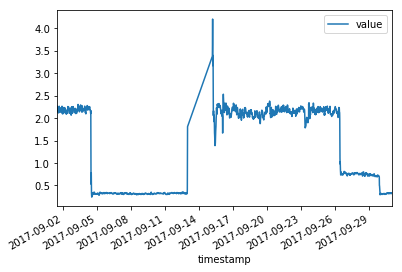

In [27]:
qual_lol = qual_all[qual_all['timestamp'] > '2017-09-01T12:00:00.000000000']
qual_lol = qual_lol[qual_lol['timestamp'] < '2017-10-01T18:30:00.000000000']
qual_lol.plot(x = 'timestamp', y = 'value')

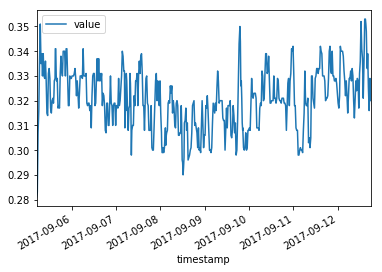

In [28]:
qual_lol = qual_all[qual_all['timestamp'] > '2017-09-05T05:00:00.000000000']
qual_lol = qual_lol[qual_lol['timestamp'] < '2017-09-12T18:30:00.000000000']
qual_lol.plot(x = 'timestamp', y = 'value')

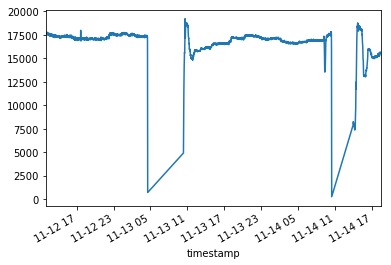

In [29]:
gb_lol = gb[gb.index > '2016-11-12T12:00:00.000000000']
gb_lol = gb_lol[gb_lol.index < '2016-11-14T18:30:00.000000000']
gb_lol.plot()

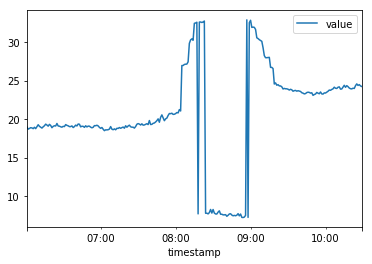

In [30]:
energy_lol = energy_all[energy_all['timestamp'] > '2017-09-07T06:00:00.000000000']
energy_lol = energy_lol[energy_lol['timestamp'] < '2017-09-07T10:30:00.000000000']
energy_lol.plot(x = 'timestamp', y = 'value')

In [82]:
eff_new = pd.DataFrame()
eff_new['timestamp'] = eff_all.groupby("timestamp").value.mean().index
eff_new['value'] = eff_all.groupby("timestamp").value.mean().values

In [83]:
eff_new['day'] = (eff_new['timestamp'].values).astype('datetime64[D]').astype(int)-np.datetime64('2016-10-01').astype('datetime64[D]').astype(int)

In [63]:
lol = eff_new.groupby('day').value.mean()
lol.head()

day
0    17138.604496
1    17260.405627
2    17266.331459
3    17257.291270
4    17297.343270
Name: value, dtype: float64

In [84]:
mean = eff_new.groupby("day").value.mean()
df = pd.DataFrame({'mean_value': mean, 'day': eff_new['day'].unique()})
eff_new = pd.merge(eff_new, df, how = 'left', on = 'day')
eff_new


,timestamp,value,day,mean_value
0,2016-10-01 00:00:00,16751.067273,0,17138.604496
1,2016-10-01 00:01:00,16669.921667,0,17138.604496
2,2016-10-01 00:02:00,16979.655833,0,17138.604496
3,2016-10-01 00:03:00,16527.832500,0,17138.604496
4,2016-10-01 00:04:00,16829.427500,0,17138.604496
5,2016-10-01 00:05:00,16781.086667,0,17138.604496
6,2016-10-01 00:06:00,16684.245000,0,17138.604496
7,2016-10-01 00:07:00,16748.291667,0,17138.604496
8,2016-10-01 00:08:00,16735.678333,0,17138.604496
9,2016-10-01 00:09:00,16825.033333,0,17138.604496


In [85]:
mean = eff_new.groupby('day').value.mean()
days = np.arange(0, 360)

df = pd.DataFrame({'days':days, 'mean':mean})

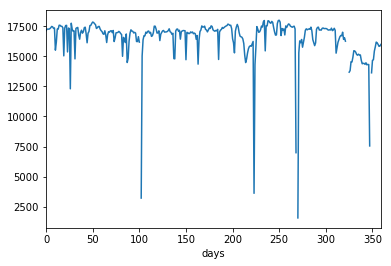

In [88]:
ser = pd.Series(data = df['mean'], index=df['days'])
ser.plot()

In [96]:
def my_plot_anomaly(ser, low, upper):
    ser = ser[(ser > low) & (ser < upper)]
    ser.plot()

## ser.diff(1)
ser.plot()

In [98]:
ser = ser[(ser > 12500.) & (ser < 18000.)]

In [99]:
from statsmodels.tsa.arima_model import ARIMA

In [100]:
model = ARIMA(ser, order = (5, 1, 0))
model_fit = model.fit(disp = 0)
print(model_fit.summary())
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

ValueError: Given a pandas object and the index does not contain dates

In [35]:
eff_new.head()
eff_new['diff'] = eff_new['value'] - eff_new['day_mean']

KeyError: 'day_mean'

In [160]:
eff_new.head(300)

,timestamp,value,day,day_mean,diff
0,2016-10-01 00:00:00,16751.067273,0,17138.604496,-387.537223
1,2016-10-01 00:01:00,16669.921667,0,17260.405627,-590.483960
2,2016-10-01 00:02:00,16979.655833,0,17266.331459,-286.675626
3,2016-10-01 00:03:00,16527.832500,0,17257.291270,-729.458770
4,2016-10-01 00:04:00,16829.427500,0,17297.343270,-467.915770
5,2016-10-01 00:05:00,16781.086667,0,17373.285393,-592.198726
6,2016-10-01 00:06:00,16684.245000,0,17482.902422,-798.657422
7,2016-10-01 00:07:00,16748.291667,0,17456.787579,-708.495913
8,2016-10-01 00:08:00,16735.678333,0,17321.541142,-585.862808
9,2016-10-01 00:09:00,16825.033333,0,17363.399034,-538.365700
